# Web Scraping

In [ ]:
# importing libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
import numpy as np
import pandas as pd
import time

In [ ]:
# initializing web driver
driver = webdriver.Chrome() 
driver.get("https://www.swiggy.com/restaurants")

In [ ]:
# creating dictonary for data storage
Skeleton  = {
    "Name" : [],
    "Cuisines" : [],
    "Rating" : [],
    "Price" : [],
}

In [ ]:
# Wait until the body tag is present
element = WebDriverWait(driver, 20).until(
    EC.visibility_of_element_located((By.TAG_NAME, "body"))
)


In [ ]:
# Set the loop index and data retrieval inside the loop
index = 0

# While loop allows re-fetching elements after navigating back
while True:
    driver.find_element(By.TAG_NAME, "body").send_keys(Keys.PAGE_DOWN)
    time.sleep(np.random.randint(2))  # Add a delay if necessary

    # Refresh the main page elements each time we return to it
    data = driver.find_elements(By.CSS_SELECTOR, ".sc-bdOgaJ.dahwTg")

    # Break if all elements are processed
    if index >= len(data):
        break

    # Work with the current element
    i = data[index]
    
    # Extract the main page information
    try:
        # Extract Name
        name = i.find_element(By.CSS_SELECTOR, ".sc-aXZVg.kVQudY").text
        print("Name:", name)
        Skeleton["Name"].append(name)
    except:
        Skeleton["Name"].append(None)

    # Extract Location and Cuisines
    sub = i.find_elements(By.CLASS_NAME, "sw-restaurant-card-descriptions-container")
    if sub:
        try:
            cuisines = sub[0].text
            print("Cuisines:", cuisines)
            Skeleton["Cuisines"].append(cuisines)
        except:
            Skeleton["Cuisines"].append(None)
    
    
    # Click the element to navigate to the detail page
    try:
        i.click()
        
        # Wait for a specific element on the detail page to load
        wait = WebDriverWait(driver, np.random.randint(5,10))
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, ".sc-hcFBEE.jCzhZz")))
        
        # Extract Rating and Price from the detail page
        detail_elements = driver.find_elements(By.CSS_SELECTOR, ".sc-aXZVg.eqdoYF")
        if detail_elements:
            try:
                rating = detail_elements[1].text
                print("Rating:", rating)
                Skeleton["Rating"].append(rating)
            except:
                Skeleton["Rating"].append(None)

            try:
                price = detail_elements[2].text
                print("Price:", price)
                Skeleton["Price"].append(price)
            except:
                Skeleton["Price"].append(None)
    
    except Exception as e:
        print("Error navigating or extracting detail page data:", e)
    
    finally:
        # Always go back to the main page, regardless of any errors
        driver.back()
        time.sleep(np.random.randint(2,5))  # Wait for the main page to reload
    
    # Move to the next element
    index += 1
    print("_______________________________")

Name: Pizza Hut
Cuisines: Pizzas
Shanti Nagar
Rating: 4.3 (10K+ ratings)
Price: ₹600 for two


In [ ]:
# create the dataframe
df = pd.DataFrame(Skeleton)


In [108]:
# Split the column by '\n' and create a new column for the part after '\n'
df[['Cuisines', 'Location']] = df['Cuisines'].str.split(r'\n', expand=True)


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Name      54 non-null     object
 1   Location  54 non-null     object
 2   Cuisines  54 non-null     object
 3   Rating    54 non-null     object
 4   Price     54 non-null     object
dtypes: object(5)
memory usage: 2.2+ KB


In [111]:
# Extract the rating value as a float
df['Ratings'] = pd.to_numeric(df['Rating'].str.extract(r'(\d+\.\d)')[0], errors='coerce')

# Extract the numeric part of the review count and convert it to integer thousands
df['Review'] = df['Rating'].str.extract(r'\((\d+\.?\d*)[K]')[0]

# Convert the extracted review count to numeric, multiply by 1000, and handle NaN
df['Review'] = pd.to_numeric(df['Review'], errors='coerce').fillna(0).astype(int) * 1000

In [112]:
df['Price'] = df['Price'].str.extract(r'₹(\d+)')[0]

In [ ]:
df = df.drop("Rating",axis=1)

In [123]:
df.head()

,Name,Location,Cuisines,Price,Ratings,Review
0,Pizza Hut,Shanti Nagar,Pizzas,600,4.3,10000
1,Chinese Wok,Malleshwaram,"Chinese, Asian, Tibetan, Desserts",250,4.4,1000
2,KFC,Central Bangalore,"Burgers, Fast Food, Rolls & Wraps",400,4.4,2000
3,Burger King,Shivaji Nagar,"Burgers, American",350,4.4,37000
4,Domino's Pizza,Brigade Road,"Pizzas, Italian, Pastas, Desserts",400,4.4,5000


# Data Analysis

### 1. Top Trending Dishes in Bangalore: Section 01 - IP105 (PSC-2)

#### • Scrape the top trending dishes based on restaurant menus or customer reviews in Bangalore. 

In [124]:
df['Cuisines'] = df['Cuisines'].astype(str) 
cuisine_list = df['Cuisines'].str.split(', ')  # Split the cuisines by comma and space

# Explode the DataFrame to have one cuisine per row
exploded_data = df.explode('Cuisines')

# Filter for highly rated and reviewed cuisines
filtered_data = exploded_data[(exploded_data['Ratings'] >= 4.0) & (exploded_data['Review'] > 1000)]

# Count the frequency of each cuisine
trending_cuisines = filtered_data['Cuisines'].value_counts()

# Display the top trending cuisines
print("Top Trending Cuisines in Bangalore:")
print(trending_cuisines.head(10))

Top Trending Cuisines in Bangalore:
Cuisines
Pizzas                                                              1
Healthy Food, Continental, Italian, Pastas, Desserts, Salads        1
Desserts, Ice Cream, Bakery                                         1
Biryani, Tandoor, Kebabs, Barbecue                                  1
Desserts, Snacks, Chaat, Ice Cream                                  1
Continental, Pastas, Salads, Snacks, Desserts, Fast Food, French    1
Andhra, South Indian, Biryani, Beverages, Desserts                  1
Sweets, Chaat                                                       1
Chinese, Snacks                                                     1
Chinese, Beverages                                                  1
Name: count, dtype: int64


#### • Provide a list of at least 10 trending dishes and mention their frequency of appearance in your data. 

In [125]:
cuisine_list = df['Cuisines'].str.split(', ')  # Split the cuisines by comma and space

# Count the frequency of each cuisine
cuisine_frequency = exploded_data['Cuisines'].value_counts()

# Display the top 10 trending dishes with their frequencies
top_trending_dishes = cuisine_frequency.head(10)

# Print the results
print("Top Trending Dishes in Bangalore and Their Frequencies:")
print(top_trending_dishes)

Top Trending Dishes in Bangalore and Their Frequencies:
Cuisines
Pizzas                                          1
Chinese, Beverages                              1
Healthy Food, Salads, Keto, Snacks              1
Home Food, Indian, North Indian, Thalis         1
North Indian, Punjabi, Home Food                1
Andhra                                          1
South Indian, Fast Food, Juices                 1
Sweets, Bakery                                  1
Pizzas, Pastas, Italian, Desserts, Beverages    1
Salads, Snacks, Desserts, Beverages             1
Name: count, dtype: int64


#### • Group the dishes by cuisine type (e.g., Indian, Chinese, Continental)

In [126]:
# Create a mapping of specific dishes to broader cuisine types
cuisine_mapping = {
    'Biryani': 'Indian',
    'North Indian': 'Indian',
    'Punjabi': 'Indian',
    'Desserts': 'Dessert',
    'Pizzas': 'Italian',
    'Italian': 'Italian',
    'Pastas': 'Italian',
    'Burgers': 'Fast Food',
    'Fast Food': 'Fast Food',
    'Tandoor': 'Indian',
    'Kebabs': 'Indian',
    'Barbecue': 'Indian',
    'Healthy Food': 'Continental',
    'Continental': 'Continental',
    'Rolls & Wraps': 'Indian',
}

# Map the cuisines to their types
exploded_data['Cuisine Type'] = exploded_data['Cuisines'].map(cuisine_mapping)

#  Group by Cuisine Type and count frequencies
grouped_cuisines = exploded_data.groupby('Cuisine Type')['Cuisines'].count()

# Display the results
print("Frequency of Dishes by Cuisine Type:")
print(grouped_cuisines)

Frequency of Dishes by Cuisine Type:
Cuisine Type
Italian    1
Name: Cuisines, dtype: int64


## 2. Top Restaurants in Bangalore: 

#### • Identify the top restaurants in Bangalore based on factors such as ratings, reviews, or popularity. 

In [127]:
top_restaurants = df.sort_values(by=['Ratings', 'Review'], ascending=False)

top_restaurants = top_restaurants.head(10)

print("Top Restaurants in Bangalore Based on Ratings and Reviews:")
top_restaurants[['Name', 'Location', 'Cuisines', 'Price', 'Ratings', 'Review']]

Top Restaurants in Bangalore Based on Ratings and Reviews:


,Name,Location,Cuisines,Price,Ratings,Review
23,Subko Specialty Coffee Roasters,Central Bangalore,"Beverages, Desserts, Bakery, Fast Food",800,4.8,0
14,Meghana Foods,Residency Road,"Biryani, Andhra, South Indian, Chinese, Seafood",500,4.7,80000
39,Anand Sweets & Savouries,Shivajinagar,"Sweets, Chaat, Snacks, Desserts, North Indian",200,4.7,21000
21,Kanti Sweets,Central Bangalore,Sweets,150,4.7,5000
15,Theobroma,Ashok Nagar,"Desserts, Bakery, Beverages",400,4.7,4000
29,"WeFit - Protein Bowls, Salads & Sandwiches",Santhinagar,"Healthy Food, Salads, Keto, Snacks",250,4.7,0
43,Nagarjuna - Since 1984,Ashok Nagar,"Andhra, South Indian, Biryani, Beverages, Dess...",600,4.6,45000
13,A2B - Adyar Ananda Bhavan,Shanti Nagar,"South Indian, North Indian, Sweets, Chinese",300,4.6,29000
45,Richie Rich,Race Course Road,"Desserts, Snacks, Chaat, Ice Cream",500,4.6,16000
28,Fresh Pressery Cafe,Central Bangalore,"Healthy Food, Continental, Italian, Pastas, De...",1000,4.6,7000


#### • Provide a ranking of the top 10 restaurants, including details such as their average rating, number of reviews, and price range.

In [128]:
grouped_data = df.groupby('Name').agg(
    Average_Rating=('Ratings', 'mean'),
    Total_Reviews=('Review', 'sum'),
    Price_Range=('Price', lambda x: f"{x.min()} - {x.max()}")
).reset_index()

# Sort by Average Rating and Total Reviews
ranked_restaurants = grouped_data.sort_values(by=['Average_Rating', 'Total_Reviews'], ascending=False)

# Select the top 10 restaurants
top_10_restaurants = ranked_restaurants.head(10)

# Display the ranking of top 10 restaurants
print("Ranking of Top 10 Restaurants in Bangalore:")
top_10_restaurants[['Name', 'Average_Rating', 'Total_Reviews', 'Price_Range']]

Ranking of Top 10 Restaurants in Bangalore:


,Name,Average_Rating,Total_Reviews,Price_Range
43,Subko Specialty Coffee Roasters,4.8,0,800 - 800
29,Meghana Foods,4.7,80000,500 - 500
4,Anand Sweets & Savouries,4.7,21000,200 - 200
22,Kanti Sweets,4.7,5000,150 - 150
50,Theobroma,4.7,4000,400 - 400
52,"WeFit - Protein Bowls, Salads & Sandwiches",4.7,0,250 - 250
32,Nagarjuna - Since 1984,4.6,45000,600 - 600
1,A2B - Adyar Ananda Bhavan,4.6,29000,300 - 300
39,Richie Rich,4.6,16000,500 - 500
19,Fresh Pressery Cafe,4.6,7000,1000 - 1000


## 3. Restaurant Rating Analysis: 

#### • Scrape the ratings of restaurants in Bangalore and analyze the distribution of ratings.

Descriptive Statistics for Restaurant Ratings:
count    54.000000
mean      4.492593
std       0.137157
min       4.100000
25%       4.400000
50%       4.500000
75%       4.600000
max       4.800000
Name: Ratings, dtype: float64


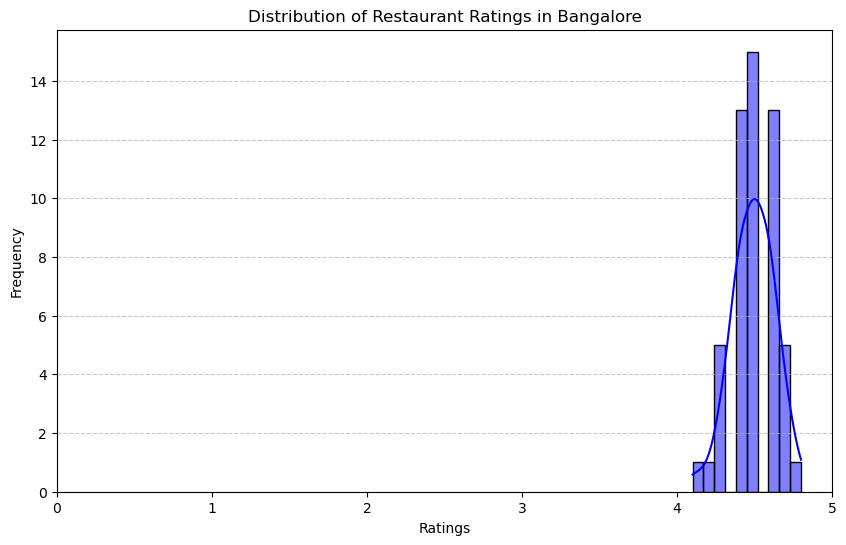

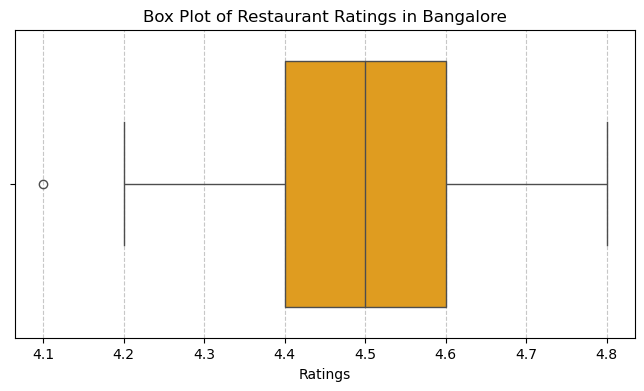

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

ratings_summary = df['Ratings'].describe()
print("Descriptive Statistics for Restaurant Ratings:")
print(ratings_summary)

# Step 3: Visualization of Ratings Distribution
plt.figure(figsize=(10, 6))

# Histogram
sns.histplot(df['Ratings'], bins=10, kde=True, color='blue', edgecolor='black')
plt.title('Distribution of Restaurant Ratings in Bangalore')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.xlim(0, 5)  # Assuming ratings are between 0 and 5
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Box Plot
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Ratings'], color='orange')
plt.title('Box Plot of Restaurant Ratings in Bangalore')
plt.xlabel('Ratings')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### • Break down the ratings analysis by price category (e.g., affordable, mid-range, premium) and cuisine type.

In [130]:
df["Price"]=df["Price"].astype("int")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      54 non-null     object 
 1   Location  54 non-null     object 
 2   Cuisines  54 non-null     object 
 3   Price     54 non-null     int32  
 4   Ratings   54 non-null     float64
 5   Review    54 non-null     int32  
dtypes: float64(1), int32(2), object(3)
memory usage: 2.2+ KB


In [131]:
def price_category(price):
    if price < 300:
        return 'Affordable'
    elif 300 <= price < 600:
        return 'Mid-range'
    else:
        return 'Premium'

# Apply the function to create a new column for Price Category
df['Price_Category'] = df['Price'].apply(price_category)

df

,Name,Location,Cuisines,Price,Ratings,Review,Price_Category
0,Pizza Hut,Shanti Nagar,Pizzas,600,4.3,10000,Premium
1,Chinese Wok,Malleshwaram,"Chinese, Asian, Tibetan, Desserts",250,4.4,1000,Affordable
2,KFC,Central Bangalore,"Burgers, Fast Food, Rolls & Wraps",400,4.4,2000,Mid-range
3,Burger King,Shivaji Nagar,"Burgers, American",350,4.4,37000,Mid-range
4,Domino's Pizza,Brigade Road,"Pizzas, Italian, Pastas, Desserts",400,4.4,5000,Mid-range
5,Kwality Walls Ice Cream and More,Shanthinagar,"Desserts, Ice Cream, Ice Cream Cakes",200,4.4,0,Affordable
6,The Belgian Waffle Co.,Seshadripuram,"Waffle, Desserts, Ice Cream, Beverages",200,4.6,2000,Affordable
7,Andhra Gunpowder,Seshadripuram,"Andhra, Biryani, South Indian",350,4.6,2000,Mid-range
8,Mani's Dum Biryani,Ulsoor,"Andhra, Biryani, North Indian",499,4.5,22000,Mid-range
9,McDonald's,Ashok Nagar,"Burgers, Beverages, Cafe, Desserts",400,4.4,25000,Mid-range


#### • Provide insights into how ratings vary with price and cuisine. Are premium restaurants rated better on average?

Average Ratings by Price Category:
  Price_Category  Average_Rating
0     Affordable        4.546154
1      Mid-range        4.466667
2        Premium        4.492857


C:\Users\chats\AppData\Local\Temp\ipykernel_14184\2863768396.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Price_Category', y='Average_Rating', data=ratings_summary, palette='viridis')


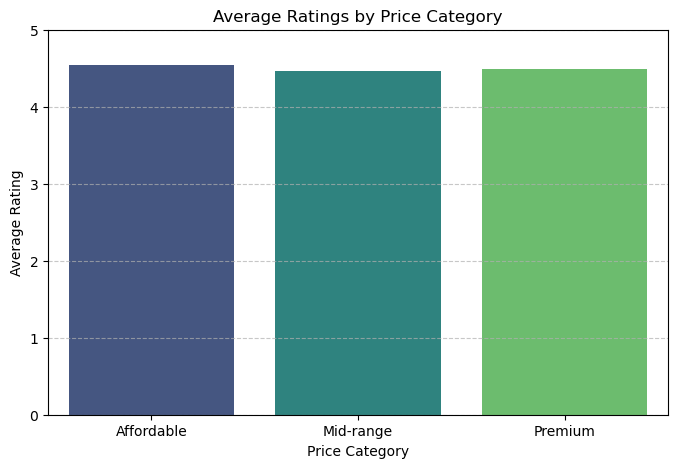

In [132]:
ratings_summary = df.groupby('Price_Category')['Ratings'].mean().reset_index()
ratings_summary.columns = ['Price_Category', 'Average_Rating']

# Print the average ratings by price category
print("Average Ratings by Price Category:")
print(ratings_summary)

# Visualization
plt.figure(figsize=(8, 5))
sns.barplot(x='Price_Category', y='Average_Rating', data=ratings_summary, palette='viridis')
plt.title('Average Ratings by Price Category')
plt.xlabel('Price Category')
plt.ylabel('Average Rating')
plt.ylim(0, 5)  # Assuming ratings are between 0 and 5
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 4. Average Cost for Two Analysis

#### • Scrape the average cost for two people across restaurants in Bangalore. 

In [133]:
df['Cost_for_Two'] = df['Price'] * 2

# Calculate the Average Cost for Two
average_cost = df['Cost_for_Two'].mean()

print(f"The average cost for two people across restaurants in Bangalore is: ₹{average_cost:.2f}")

The average cost for two people across restaurants in Bangalore is: ₹952.56


#### Analyze the distribution of restaurant prices in different areas of Bangalore.

In [134]:
price_distribution = df.groupby('Location')['Price'].describe().reset_index()

# Print the price distribution summary
price_distribution



,Location,count,mean,std,min,25%,50%,75%,max
0,Ashok Nagar,5.0,460.000000,89.442719,400.0,400.0,400.0,500.0,600.0
1,Basavanagudi,2.0,275.000000,35.355339,250.0,262.5,275.0,287.5,300.0
2,Brigade Road,2.0,900.000000,707.106781,400.0,650.0,900.0,1150.0,1400.0
3,Central Bangalore,15.0,550.000000,201.777813,150.0,450.0,500.0,650.0,1000.0
4,Church Street,2.0,1100.000000,141.421356,1000.0,1050.0,1100.0,1150.0,1200.0
5,Commercial Street,1.0,200.000000,NaN,200.0,200.0,200.0,200.0,200.0
6,Cunningham Road,2.0,360.000000,127.279221,270.0,315.0,360.0,405.0,450.0
7,Frazer Town,2.0,275.000000,35.355339,250.0,262.5,275.0,287.5,300.0
8,Indiranagar,1.0,600.000000,NaN,600.0,600.0,600.0,600.0,600.0
9,Jayamahal Extension,1.0,150.000000,NaN,150.0,150.0,150.0,150.0,150.0


#### • Identify the most expensive and most affordable neighborhoods for dining.

In [135]:
average_price_by_neighborhood = df.groupby('Location')['Price'].mean().reset_index()

# Rename columns for clarity
average_price_by_neighborhood.columns = ['Neighborhood', 'Average_Price']

# Identify Most Expensive and Most Affordable Neighborhoods
most_expensive = average_price_by_neighborhood.loc[average_price_by_neighborhood['Average_Price'].idxmax()]
most_affordable = average_price_by_neighborhood.loc[average_price_by_neighborhood['Average_Price'].idxmin()]

# Print results
print(f"The most expensive neighborhood for dining is: {most_expensive['Neighborhood']} with an average price of ₹{most_expensive['Average_Price']:.2f}.")
print(f"The most affordable neighborhood for dining is: {most_affordable['Neighborhood']} with an average price of ₹{most_affordable['Average_Price']:.2f}.")

The most expensive neighborhood for dining is: Church Street with an average price of ₹1100.00.
The most affordable neighborhood for dining is: Jayamahal Extension with an average price of ₹150.00.


 5. Cuisine Popularity Analysis: 

• Scrape data related to the types of cuisines offered by restaurants. 

In [136]:
# Split the Cuisines column into separate cuisines
df['Cuisines'] = df['Cuisines'].str.split(',')

# Explode the Cuisines column to count each type separately
cuisines_exploded = df.explode('Cuisines')

# Strip whitespace and count the frequency of each cuisine
cuisines_exploded['Cuisines'] = cuisines_exploded['Cuisines'].str.strip()
cuisine_counts = cuisines_exploded['Cuisines'].value_counts().reset_index()
cuisine_counts.columns = ['Cuisine', 'Frequency']

# Print the frequency of each cuisine
print(cuisine_counts)


            Cuisine  Frequency
0          Desserts         21
1         Beverages         14
2           Chinese         14
3           Biryani         11
4            Snacks          9
5      South Indian          9
6       Continental          8
7      North Indian          7
8            Andhra          7
9            Pizzas          6
10          Seafood          6
11           Bakery          6
12           Pastas          6
13        Fast Food          6
14           Indian          5
15        Ice Cream          5
16          Italian          5
17           Sweets          5
18     Healthy Food          4
19           Salads          4
20            Chaat          3
21          Tandoor          3
22          Burgers          3
23            Asian          3
24           Kerala          3
25             Cafe          3
26         American          3
27          Punjabi          2
28          Tibetan          2
29        Home Food          2
30      Mangalorean          2
31      

#### • Analyze which cuisines are most popular in Bangalore, based on the number of restaurants offering each type of cuisine.

In [137]:
cuisines_exploded['Cuisines'] = cuisines_exploded['Cuisines'].str.strip()
cuisine_counts = cuisines_exploded['Cuisines'].value_counts().reset_index()
cuisine_counts.columns = ['Cuisine', 'Number_of_Restaurants']

# Sort the results by Number_of_Restaurants in descending order
cuisine_counts = cuisine_counts.sort_values(by='Number_of_Restaurants', ascending=False)

cuisine_counts

,Cuisine,Number_of_Restaurants
0,Desserts,21
2,Chinese,14
1,Beverages,14
3,Biryani,11
4,Snacks,9
5,South Indian,9
6,Continental,8
7,North Indian,7
8,Andhra,7
12,Pastas,6
